In [1]:
import sys
sys.path.insert(0, "..")
from src.settings import StyleSettings
from src.data.data_tools import StyleDataset
import numpy as np
import seaborn as sns


# Implementation of question 6 a custom model to try to improve performance

# Load the data

In [2]:
settings = StyleSettings()
traindataset = StyleDataset([settings.trainpath])
testdataset = StyleDataset([settings.testpath])


We have 419 batches in the dataset

In [3]:
len(traindataset) // 32


419

In [4]:
x, y = traindataset[42]
x, y


('Lace is an openwork fabric , patterned with open holes in the work , made by machine or by hand.',
 'wiki')

Every batch is a `Tuple[str, str]` of a sentence and a label. We can see this is a classification task.
The task is, to classify sentences in four categories.
Lets build a vocabulary by copy-pasting the code we used before

In [5]:
from src.models import tokenizer

corpus = []
for i in range(len(traindataset)):
    x = tokenizer.clean(traindataset[i][0])
    corpus.append(x)
v = tokenizer.build_vocab(corpus, max=20000)
len(v)


2022-06-28 11:12:03.252 | INFO     | src.models.tokenizer:build_vocab:27 - Found 19306 tokens


19308

We need to cast the labels to an integers. You can use this dictionary to do so:

In [6]:
d = {"humor": 0, "reuters": 1, "wiki": 2, "proverbs": 3}
d[y]


2

# Question 2 : Implement a preprocessor

We can inherit from `tokenizer.Preprocessor`
Only thing we need to adjust is the `cast_label` function.
 
- create a StylePreprocessor class
- inherit from Preprocessor
- create a new cast_label function for this dataset

In [7]:

# TODO ~ about 4 lines of code
class StylePreprocessor(tokenizer.Preprocessor):
    def cast_label(self, label: str) -> int:
        d = {"humor": 0, "reuters": 1, "wiki": 2, "proverbs": 3}
        return d[label]
    pass


To test the preprocessor:

In [8]:
preprocessor = StylePreprocessor(max=100, vocab=v, clean=tokenizer.clean)
preprocessor([(x, y)])


(tensor([[4929,  854,   32,   15,  499,   21, 8496,  890]], dtype=torch.int32),
 tensor([2]))

# Set up the model
We can re-use the BaseDatastreamer

In [9]:
from src.data import data_tools

trainstreamer = data_tools.BaseDatastreamer(
    dataset=traindataset, batchsize=32, preprocessor=preprocessor
).stream()
teststreamer = data_tools.BaseDatastreamer(
    dataset=testdataset, batchsize=32, preprocessor=preprocessor
).stream()


In [10]:
x, y = next(trainstreamer)
x.shape, y


(torch.Size([32, 22]),
 tensor([2, 1, 2, 2, 2, 0, 0, 2, 1, 1, 0, 1, 1, 0, 0, 0, 1, 3, 0, 1, 2, 3, 1, 2,
         1, 0, 1, 2, 0, 0, 1, 0]))

your explanation here

# 6 Tune the model
Don't overdo this.
More is not better.

Bonus points for things like:
- Attention layers
- Trax architecture including a functioning training loop

Keep it small! It's better to present 2 or 3 sane experiments that are structured and thought trough, than 25 random guesses. You can test more, but select 2 or 3 of the best alternatives you researched, with a rationale why this works better.

Keep it concise; explain:
- what you changed
- why you thought that was a good idea  
- what the impact was (visualise or numeric)
- explain the impact

You dont need to get a perfect score; curiousity driven research that fails is fine.
The insight into what is happening is more important than the quantity.

Keep logs of your settings;
either use gin, or save configs, or both :)
Store images in the `figures` folder.

<b>We choose to implement the model in Traxx.
We also implement a simple learning rate scheduler 

In [11]:

import jax.numpy as jnp
import trax
from trax.supervised.lr_schedules import warmup_and_rsqrt_decay
from trax.layers.assert_shape import assert_shape
from trax.layers import combinators as cb
from trax.shapes import signature
from trax import layers as tl
from typing import Dict

# implement a learning rate scheduler
lr = warmup_and_rsqrt_decay(100, 0.01)




2022-06-28 11:12:04.516853: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


First we create a pipeline using the streamers we already have

In [12]:
def Cast():
    def f(generator):
        for x, y in generator:
            yield x.numpy(), y.numpy()

    return lambda g: f(g)

In [13]:
data_pipeline = trax.data.Serial(Cast())
trainpipe = data_pipeline(trainstreamer)
testpipe = data_pipeline(teststreamer)

In [14]:
X, y = next(trainpipe)
type(X), type(y)


(numpy.ndarray, numpy.ndarray)

We create a simple function to write to config.

In [15]:
def write_config(dir: str, config: dict, model: trax.layers.combinators.Serial) -> None:
    path = dir / "saved_config.json"
    with open(path, "w") as file:
        file.write(str(config) + str(model))

In [16]:
config = {
    "vocab": len(v),
    "hidden_size": 256,
    "features": 50,
    "output_size": 4,
    "dropout" : 0.1
}



# Models
We have a multiclass classification problem using a text sequence.
For these kinds of problems we've covered 3 models, GRU, LSTM and we've also covered .
The performance difference between GRU and LSTM depends on the specific question and dataset. Therefore we will test them both against eachother and have a small look at the hidden size.
To test and compare performance we've written a training/test loop in jax. We've also added a small function above to write the config.
The confusion matrix of question 4 has been changed to work with the different outputs. After several tests with inconsistent results we decided to increase the amount of data used by the confusion matrix. This yielded much more stabile results.

#First of the GRU model.


In [17]:
def createCustModel(config: Dict):
    """ A Custom model using embeddings, GRU
    """
    model = tl.Serial(
        tl.Embedding(vocab_size=config["vocab"], d_feature=config["hidden_size"]), #MAP to vectors
        tl.GRU(n_units=config["hidden_size"]),  #  use a gated layer to remember words from the beginning of a text to 'understand the story'
        tl.Mean(axis=1), #  take mean values of groups of words, hopefully this generalizing will fix the overfitting we found in the last question
        tl.Dense(config["output_size"]))
    return model
model = createCustModel(config)


The gru model performs admirably with hidden size 128. The lowest accuracy for 93% proverbs is very impressive.
02 style detection Image confusion matrix trax gru 128.png
We've also tested increasing the hidden size to 256 and this lead to somewhat worse results:
02 style detection Image confusion matrix trax gru 256.png

# The LSTM Model

In [18]:
def createCustModel2(config: Dict):
    """ A Custom model using embeddings, LSTM
    """
    model = tl.Serial(
        tl.Embedding(vocab_size=config["vocab"], d_feature=config["hidden_size"]), #MAP to vectors
        trax.layers.rnn.LSTM(n_units=config["hidden_size"]),  #  use a lstm layer
        tl.Mean(axis=1), #  take mean values of groups of words, hopefully this generalizing will fix the overfitting we found in the last question
        tl.Dense(config["output_size"]))
    return model
model = createCustModel2(config)

The LSTM model performs better on provebs but slightly worse on the other categories with hidden size 128. The lowest accuracy for 94.5% (see note) is very good. : 02 style detection Image confusion matrix trax lstm 128.png
We've also tested increasing the hidden size to 256 and this lead to sslightly better results. The proverbs now scare 95.7% and all other categories have a score of over 99%. Not too bad : 02 style detection Image confusion matrix trax gru 256.png

<b>Note:</b> Initially the results we got comparing the GRU and LSTM models were inconsistent. This was due to the low amount of data in the confusion matrix. After increasing this data tenfold we got much more consistent results.

Conclusion: bot the GRU and LSTM models using embeddings perform very well on this dataset. LSTM seems to do a little better, but looking at the accuracy rates.png image we see all 4 methods (GRU128/256 and LSTM128/256) reaching about the same limit.


In [19]:
# let's test a single prediction
model.init_weights_and_state(X)
ytest = model(X)
ytest

DeviceArray([[-1.3068055 ,  0.08752393, -0.49463323, -0.0690266 ],
             [-1.29544   ,  0.07706412, -0.50108457, -0.06702597],
             [-1.3008224 ,  0.0846278 , -0.49903283, -0.06809334],
             [-1.2970471 ,  0.07660733, -0.4977098 , -0.07212757],
             [-1.3067197 ,  0.08589704, -0.4974607 , -0.07286545],
             [-1.3058218 ,  0.08238399, -0.4959039 , -0.06930571],
             [-1.2960705 ,  0.07782198, -0.49934113, -0.06650162],
             [-1.2952679 ,  0.07514658, -0.5015878 , -0.06870562],
             [-1.3097665 ,  0.10132855, -0.4902794 , -0.06978413],
             [-1.3003281 ,  0.08241282, -0.49766716, -0.06781425],
             [-1.2996767 ,  0.08414169, -0.4954897 , -0.06891981],
             [-1.3020564 ,  0.08244856, -0.4962064 , -0.0717025 ],
             [-1.3087656 ,  0.09128572, -0.493282  , -0.06873842],
             [-1.2980204 ,  0.08297847, -0.496732  , -0.06970069],
             [-1.2981089 ,  0.08017444, -0.4987018 , -0.067308

In [20]:
from trax.supervised import training
import trax
from trax import layers as tl

log_dir = "../tune"
log_dir = data_tools.dir_add_timestamp(log_dir)

write_config(log_dir, config, model)

train_task = training.TrainTask(
    labeled_data=trainpipe,
    loss_layer=tl.CategoryCrossEntropy(),
    optimizer=trax.optimizers.Adam(),
    lr_schedule=lr, # use the lossrate scheduler
    n_steps_per_checkpoint=100, 
)

eval_task = training.EvalTask(
    labeled_data=testpipe, metrics=[tl.CategoryAccuracy(), tl.CategoryCrossEntropy()], n_eval_batches=25
)

loop = training.Loop(
    model,
    train_task,
    eval_tasks=[eval_task],
    output_dir=log_dir,
)

2022-06-28 11:12:53.124 | INFO     | src.data.data_tools:dir_add_timestamp:78 - Logging to ../tune/20220628-1112
/home/mladmin/.cache/pypoetry/virtualenvs/exam-22-AI0Wnuoo-py3.9/lib/python3.9/site-packages/jax/_src/lib/xla_bridge.py:514: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  warnings.warn(


In [21]:
loop.run(1000)

/home/mladmin/.cache/pypoetry/virtualenvs/exam-22-AI0Wnuoo-py3.9/lib/python3.9/site-packages/trax/layers/base.py:851: FutureWarning: GzipFile was opened for writing, but this will change in future Python releases.  Specify the mode argument for opening it for writing.
  with gzip.GzipFile(fileobj=f, compresslevel=compresslevel) as gzipf:



Step      1: Total number of trainable weights: 5469188
Step      1: Ran 1 train steps in 3.18 secs
Step      1: train CategoryCrossEntropy |  1.61792862


/home/mladmin/.cache/pypoetry/virtualenvs/exam-22-AI0Wnuoo-py3.9/lib/python3.9/site-packages/trax/supervised/training.py:1249: FutureWarning: GzipFile was opened for writing, but this will change in future Python releases.  Specify the mode argument for opening it for writing.
  with gzip_lib.GzipFile(fileobj=f, compresslevel=2) as gzipf:


Step      1: eval      CategoryAccuracy |  0.33000000
Step      1: eval  CategoryCrossEntropy |  1.55515612

Step    100: Ran 99 train steps in 60.76 secs
Step    100: train CategoryCrossEntropy |  1.04110670
Step    100: eval      CategoryAccuracy |  0.82000000
Step    100: eval  CategoryCrossEntropy |  0.49386742

Step    200: Ran 100 train steps in 21.08 secs
Step    200: train CategoryCrossEntropy |  0.41259167
Step    200: eval      CategoryAccuracy |  0.87875000
Step    200: eval  CategoryCrossEntropy |  0.36403027

Step    300: Ran 100 train steps in 19.72 secs
Step    300: train CategoryCrossEntropy |  0.31493673
Step    300: eval      CategoryAccuracy |  0.90500000
Step    300: eval  CategoryCrossEntropy |  0.26179934

Step    400: Ran 100 train steps in 14.24 secs
Step    400: train CategoryCrossEntropy |  0.24829519
Step    400: eval      CategoryAccuracy |  0.91625000
Step    400: eval  CategoryCrossEntropy |  0.24251591

Step    500: Ran 100 train steps in 12.69 secs
Step 

In [22]:
# test a prediction
X, y = next(trainpipe)

yhat = model(X)
print(y[0])
print(yhat[0].argmax())


1
1


In [27]:
X, y = next(testpipe)
yhat = model(X)

for i in range(0,len(y)):
    yhati = yhat[i].argmax()
    if y[i] != yhati:
        print(str(y[i]) + "-" + str(yhati))


0-2
3-2
3-2


Let's create a new confusion matrix to see how it performs.

/home/mladmin/.cache/pypoetry/virtualenvs/exam-22-AI0Wnuoo-py3.9/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/mladmin/.cache/pypoetry/virtualenvs/exam-22-AI0Wnuoo-py3.9/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<AxesSubplot:xlabel='Predicted', ylabel='Target'>

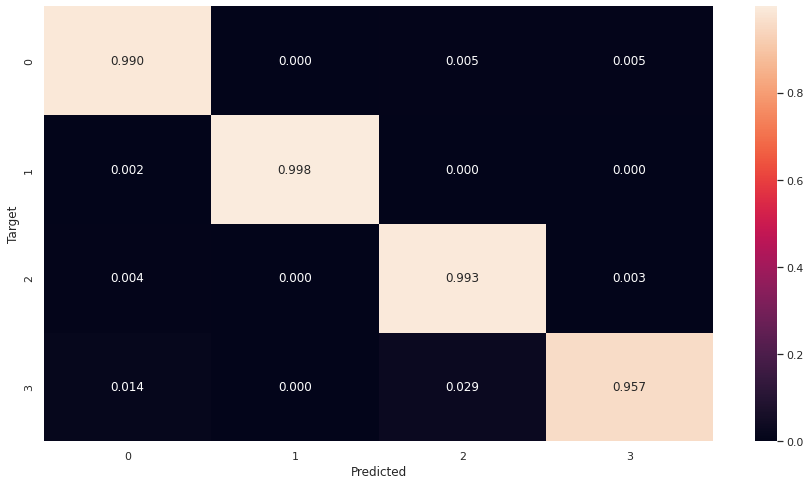

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
sns.set(rc = {'figure.figsize':(15,8)})
y_true = []
y_pred = []

for _ in range(100): #increase the range for better prediction
    X, y = next(trainpipe)
    yhat = model(X)
    predlist = list()
    truelist = list()
    for ytrue in y:
        truelist.append(int(ytrue))
    for yh1 in yhat:
        predlist.append(int(yh1.argmax()))    
    y_pred.append(predlist)
    y_true.append(truelist)


yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm_norm = cfm / np.sum(cfm, axis=1, keepdims=True)
plot = sns.heatmap(cfm_norm, annot=cfm_norm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")
plot

Both the GRU and LSTM models perform much better then the original